# Process & Visualize ROI

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
from skimage import io

import processROI

### test_get_masks

### Get the masks

In [2]:
maskPattern = (
        "data/190603/aligned/" +
        "field2_00001_masks/*.bmp"
    )
masks = processROI.get_masks(maskPattern)

### Get the TIFF stack

In [3]:
tiffsPattern = (
    "data/190603/aligned/" +
    "HN1953_190603_field2_00001_0000*.tif"
)
import glob
stack = processROI.open_TIFF_stack(tiffsPattern)
print(stack.shape)

(12048, 512, 512)


### Get ROI Averages

In [4]:
ROIaverages = processROI.cut_to_averages(stack, masks)
assert np.all(ROIaverages != 0)

## Process & Show
Using only a single example session

## Trial Averages

Looking at a window 500ms before to 1500ms after inhalation onset

In [5]:
h5Filename = (
    "data/190603/" +
#     "1953_1_04_D2019_6_3T12_29_13_odor.h5"
    "1953_1_05_D2019_6_3T12_47_22_odor.h5"
)

## Get Clean Frame Triggers

In [6]:
frameTriggers = processROI.get_flatten_trial_data(h5Filename, 'frame_triggers')
print(f"Frame triggers: {frameTriggers.shape}")
print(f"TIFF stack shape: {stack.shape}")

Frame triggers: (12036,)
TIFF stack shape: (12048, 512, 512)


Frame triggers can sometimes be mislabeled, but can also simply be dropped.
Worse, drops can come in streaks that will misalign the subsequent tiff frames from the h5 trial metadata.

We can catch both of these issues by examining the interframe intervals.
Anything higher than 34ms (1 frame) is a concern, but it seems that errors are almost always 434ms (13 frames).

If they are immediately followed by a -367ms (-11 frame) gap, it is a simple mislabel and should be corrected.
Otherwise, it is a gap, and the missing frame triggers should be inserted.

In [7]:
interFrameIntervals = frameTriggers[1:] - frameTriggers[:-1]
largeGapsIndexes = (interFrameIntervals > 34).nonzero()[0]
print(f"Greater than 34ms IFI at {largeGapsIndexes}")
print(f"Their IFI values: {interFrameIntervals[largeGapsIndexes]}")

Greater than 34ms IFI at [ 635 1768 2555 6355 6895]
Their IFI values: [434. 434. 434. 435. 434.]


In [8]:
print(frameTriggers[6355:6359])
print(frameTriggers[2555:2559])

[3527057. 3527492. 3527525. 3527158.]
[3400113. 3400547. 3400180. 3400213.]


In [9]:
negativeGapsIndexes = (interFrameIntervals < 0).nonzero()[0]
print(f"Less than 0ms IFI at {negativeGapsIndexes}")
print(f"Their IFI values: {interFrameIntervals[negativeGapsIndexes]}")

Less than 0ms IFI at [1769 2556 6357 6897]
Their IFI values: [-367. -367. -367. -368.]


In [10]:
[(largeGap +1) in negativeGapsIndexes for largeGap in largeGapsIndexes]

[False, True, True, False, False]

In [11]:
print(frameTriggers[6354:6359])
print(interFrameIntervals[6354:6359])
frameTriggers[6355] - frameTriggers[6354]

[3527024. 3527057. 3527492. 3527525. 3527158.]
[  33.  435.   33. -367.   33.]


33.0

In [16]:
frameTriggers = processROI.clean_frame_trigger_data(frameTriggers)
interFrameIntervals = frameTriggers[1:] - frameTriggers[:-1]
largeGapsIndexes = (interFrameIntervals > 34).nonzero()[0]
print(f"Greater than 34ms IFI at {largeGapsIndexes}")
print(f"Their IFI values: {interFrameIntervals[largeGapsIndexes]}")

analyze_frame_triggers NOT implemented.
Greater than 34ms IFI at []
Their IFI values: []


In [17]:
negativeGapsIndexes = (interFrameIntervals < 0).nonzero()[0]
print(f"Less than 0ms IFI at {negativeGapsIndexes}")
print(f"Their IFI values: {interFrameIntervals[negativeGapsIndexes]}")

Less than 0ms IFI at []
Their IFI values: []


## Calculate frame slices

In [18]:
trialsMeta = processROI.get_trials_metadata(h5Filename)
timelocks = trialsMeta['inh_onset']
preWindow = 500
postWindow = 1500

### Check intersniff intervals compared to the frame triggers between them

Should be about equal, unless a trial lost some triggers

In [19]:
interSniffInterval = timelocks[1:].values - timelocks[:-1].values
print(interSniffInterval)

[ 8219  9694  8093  9696  9003 10210  9456  8256  9446  8412  9472  9584
  8398  9311  9230  8574  9467  8877  8276  9918 10033  8359  8429  9180
  9104  8751  9796  8630  8946  9995  9628  9051 10173  8816  8594  8587
  9373  9027  8409  8595  9785  9799  9508  9650]


In [20]:
framesPerTrial = []
import h5py
with h5py.File(h5Filename, "r") as h5File:
    for i_trial in range(1, len(h5File)):
        trial = h5File["Trial{:04d}".format(i_trial)]
        framesPerTrial.append(sum([len(event) for event in trial["frame_triggers"]]))
print(framesPerTrial)
print(np.array(interSniffInterval) / np.array(framesPerTrial[1:]))

[20, 244, 285, 231, 294, 271, 304, 283, 246, 286, 250, 283, 288, 250, 281, 278, 253, 284, 266, 246, 298, 302, 249, 253, 274, 272, 262, 293, 258, 271, 301, 281, 274, 299, 269, 256, 256, 281, 273, 251, 257, 294, 288, 283, 298]
[33.68442623 34.01403509 35.03463203 32.97959184 33.22140221 33.58552632
 33.41342756 33.56097561 33.02797203 33.648      33.46996466 33.27777778
 33.592      33.13523132 33.20143885 33.88932806 33.33450704 33.37218045
 33.64227642 33.28187919 33.2218543  33.57028112 33.31620553 33.50364964
 33.47058824 33.40076336 33.4334471  33.4496124  33.01107011 33.20598007
 34.2633452  33.03284672 34.02341137 32.7732342  33.5703125  33.54296875
 33.35587189 33.06593407 33.50199203 33.44357977 33.28231293 34.02430556
 33.59717314 32.38255034]


In [21]:
del framesPerTrial

### Setup block template

3 blocks, each block:  
- trial 1: blank
- trial 2-8: 100A -> 0A
- trial 9-15: 0A -> 100A

A and B always complement

In [22]:
import pandas as pd
numBlocks = 3
numTrials = 15
blockTemplate = {'100% A, 0% B': [2, 15],
        '90% A, 10% B': [3, 14],
        '75% A, 25% B': [4, 13],
        '50% A, 50% B': [5, 12],
        '25% A, 75% B': [6, 11],
        '10% A, 90% B': [7, 10],
        '0% A, 100% B': [8, 9],}
trialGroups = {key: (np.tile(value, (numBlocks,1)) + (np.arange(numBlocks) * numTrials).reshape(numBlocks,1)).flatten() - 1
               for key, value in blockTemplate.items()}
trialGroups = pd.DataFrame(data=trialGroups)
# Print the trial names' numbers, not the 0-index values as stored
print(trialGroups + 1)

   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0             2             3             4             5             6   
1            15            14            13            12            11   
2            17            18            19            20            21   
3            30            29            28            27            26   
4            32            33            34            35            36   
5            45            44            43            42            41   

   10% A, 90% B  0% A, 100% B  
0             7             8  
1            10             9  
2            22            23  
3            25            24  
4            37            38  
5            40            39  


In [23]:
trialPreTimelocks = pd.DataFrame()
trialPostTimelocks = pd.DataFrame()
trialTimelocks = pd.DataFrame()
for key in trialGroups:
    trialPreTimelocks[key] = timelocks.iloc[trialGroups[key]].values - preWindow
    trialPostTimelocks[key] = timelocks.iloc[trialGroups[key]].values + postWindow
    trialTimelocks[key] = timelocks.iloc[trialGroups[key]].values
print("Pretrial Timestamps")
print(trialPreTimelocks)
print("Timelock timestamps")
print(trialTimelocks)
print("Posttrial Timestamps")
print(trialPostTimelocks)

Pretrial Timestamps
   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0       3321675       3331369       3339462       3349158       3358161   
1       3440706       3431395       3422997       3413413       3403941   
2       3458510       3467977       3476854       3485130       3495048   
3       3576276       3567330       3558700       3548904       3540153   
4       3595899       3604950       3615123       3623939       3632533   
5       3715266       3705616       3696108       3686309       3676524   

   10% A, 90% B  0% A, 100% B  
0       3368371       3377827  
1       3395529       3386083  
2       3505081       3513440  
3       3531049       3521869  
4       3641120       3650493  
5       3667929       3659520  
Timelock timestamps
   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0       3322175       3331869       3339962       3349658       3358661   
1       3441206       3431895       3423497       3413913   

In [24]:
key = "100% A, 0% B"
preFrames = processROI.frame_from_timestamp(frameTriggers,trialPreTimelocks[key])
lockFrames = processROI.frame_from_timestamp(frameTriggers, trialTimelocks[key])
postFrames = processROI.frame_from_timestamp(frameTriggers,trialPostTimelocks[key])

In [25]:
print(f"Prewindow lengths for each trial: {[lock-pre for pre, lock in zip(preFrames, lockFrames)]}")

Prewindow lengths for each trial: [15, 15, 15, 15, 15, 15]


### Calc meanF

In [26]:
frameWindow = 2
print(ROIaverages.shape)
print(np.mean(ROIaverages[3520-2:3520+2, :], axis=0))
meanFs = [np.mean(ROIaverages[max(0,lock-frameWindow): lock+frameWindow,:], axis=0)
          for lock in lockFrames]
meanFs = np.array(meanFs)
print(meanFs.shape)
# print(meanFs)

(12048, 23)
[121.98715773 139.12965072  96.03623346 147.13822572 101.18123742
  54.83878505 109.4321075  105.11462471  70.66879515 172.7951399
  57.33710801 104.00413558  74.77013699  67.6465776   77.77373489
  82.34543286  99.02814885  97.4610151   73.61492773  58.32370359
  51.23873176  48.37325986  63.66758134]
(6, 23)


In [27]:
numROI = ROIaverages.shape[1]
numTrials = len(lockFrames)
maxSliceWidth = max([post - pre for pre, post in zip(preFrames, postFrames)])
trialAverageData = np.zeros((maxSliceWidth, numTrials, numROI))
zeroFrame = max(lock - pre for pre, lock in zip(preFrames, lockFrames))
# print(trialAverageData)
print(zeroFrame)

15


In [28]:
preWindows = [slice(pre,lock) for pre,lock in zip(preFrames, lockFrames)]
print(preWindows)

[slice(219, 234, None), slice(3783, 3798, None), slice(4316, 4331, None), slice(7841, 7856, None), slice(8428, 8443, None), slice(12001, 12016, None)]


In [29]:
for i_slice, slce in enumerate(preWindows):
    tempData = ROIaverages[slce,:]
#     print(tempData.shape[0])
    trialAverageData[zeroFrame-tempData.shape[0]:zeroFrame, i_slice, :] = tempData
#     print(trialAverageData[:zeroFrame,i_slice,0])

In [30]:
postWindows = [slice(lock,post) for lock,post in zip(lockFrames, postFrames)]
print(postWindows)

[slice(234, 279, None), slice(3798, 3842, None), slice(4331, 4375, None), slice(7856, 7901, None), slice(8443, 8488, None), slice(12016, 12048, None)]


In [31]:
for i_slice, slce in enumerate(postWindows):
    tempData = ROIaverages[slce,:]
#     print(tempData.shape[0])
    trialAverageData[zeroFrame:zeroFrame+tempData.shape[0], i_slice, :] = tempData
#     print(trialAverageData[zeroFrame:,i_slice,0])

### Calc dF/F

In [32]:
print(f"How many zeros in each trial? {[(trialAverageData[:,x,:]==0).nonzero()[0].shape for x in range(6)]}")

How many zeros in each trial? [(0,), (23,), (23,), (0,), (0,), (299,)]


In [33]:
dF_F = trialAverageData / meanFs.reshape(1,numTrials,numROI) - 1
dF_F[dF_F == -1] = np.nan
print(dF_F.shape)
(np.mean(dF_F,axis=2) == -1).nonzero()[0].shape

(60, 6, 23)


(0,)

In [34]:
lockOffset = list(range(-zeroFrame, maxSliceWidth-zeroFrame))
print(lockOffset)

[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


Text(0.5, 1.0, '100% A, 0% B, all ROI')

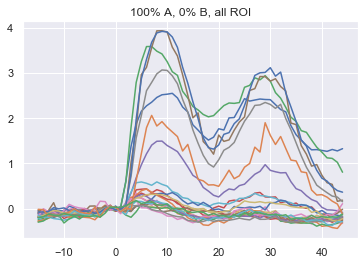

In [35]:
plt.plot(lockOffset, np.nanmean(dF_F, axis=1))
plt.title(key + ", all ROI")
# plt.legend(list(range(1, numROI+1)))

/Users/jonathanshor/.local/share/virtualenvs/rinberg-rotation-6TUwHcAB/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


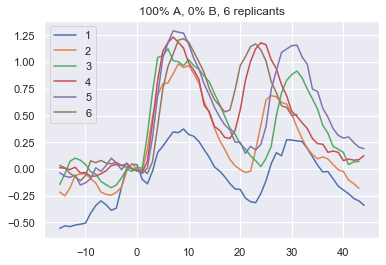

In [36]:
plt.plot(lockOffset, np.nanmean(dF_F,axis=2))
plt.title(key + ", 6 replicants")
plt.legend(list(range(1,7)))

Text(0.5, 1.0, '100% A, 0% B, Cross-trial Mean')

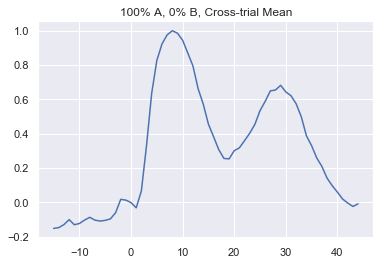

In [37]:
plt.plot(lockOffset, np.nanmean(dF_F, axis=(1,2)))
plt.title(key + ", Cross-trial Mean")